In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse

# Graph is defined in file `links.tsv`
df = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/links.tsv", 
                  skiprows=12, 
                  sep="\t", 
                  header=None)
      .applymap(urllib.parse.unquote)
      .applymap(str.strip)
      .rename(columns={0:"out",
                       1:"in"})
     )

df.sample(5)

,out,in
109317,Toronto,Hinduism
65267,List_of_countries,Canada
45822,Grand_Canyon,Rain
89110,Pumpkin,Magnesium
55392,Interpol,United_Arab_Emirates


In [2]:
# Describe df

print(f"There are {df.shape[0]} edges")
print(f"connecting {df.stack().nunique()} unique nodes in the network.")
print(f"\n\t * {df['out'].nunique()} nodes have out-links.")
print(f"\t * {df['in'].nunique()} nodes have in-links.\n")

print(f"This means {df.stack().nunique() - df['out'].nunique()} nodes are dead-ends (no out-links),")
print(f"and {df.stack().nunique() - df['in'].nunique()} \
nodes can never be reached from any other article (no in-links) ☠️")

There are 119882 edges
connecting 4592 unique nodes in the network.

	 * 4587 nodes have out-links.
	 * 4135 nodes have in-links.

This means 5 nodes are dead-ends (no out-links),
and 457 nodes can never be reached from any other article (no in-links) ☠️


In [3]:
# nodes with no outlink (dead-ends)
nodes_no_outlink = (set(df.stack()
                        .unique())
                    .difference(df['out']
                                .unique()))
print(len(nodes_no_outlink))
nodes_no_outlink

5


{'Directdebit',
 'Duchenne_muscular_dystrophy',
 "Klinefelter's_syndrome",
 'Local_community',
 'Osteomalacia'}

In [4]:
# Let's see which articles can't be reached from any other
nodes_no_inlink = list((set(df.stack()
                            .unique())
                        .difference(df['in']
                                    .unique())))
print(len(nodes_no_inlink))

nodes_no_inlink[:5]

457


['History_of_the_Grand_Canyon_area',
 'Btrieve',
 'Terik',
 'Westport_Country_Playhouse',
 'Automatic_number_plate_recognition']

### All these nodes can only be visited if they're selected as starting point.

---

In [5]:
freq_out = df['out'].value_counts()
freq_in = df['in'].value_counts()

degree_freq = (pd.merge(freq_in,
                        freq_out, 
                        left_index=True, 
                        right_index=True, 
                        how='inner')  #exclude zeros
               .fillna(0))

degree_freq.head()

,in,out
United_States,1551,294
United_Kingdom,972,168
France,959,85
Europe,933,159
England,751,172


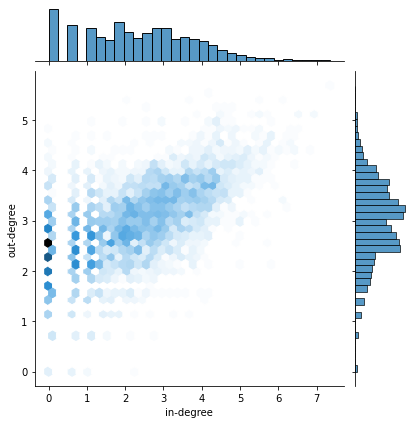

In [6]:
g = sns.jointplot(data=np.log(degree_freq), 
                  x="in", y="out", 
                  kind='hex')

g.ax_joint.set_xlabel("in-degree")
g.ax_joint.set_ylabel("out-degree");

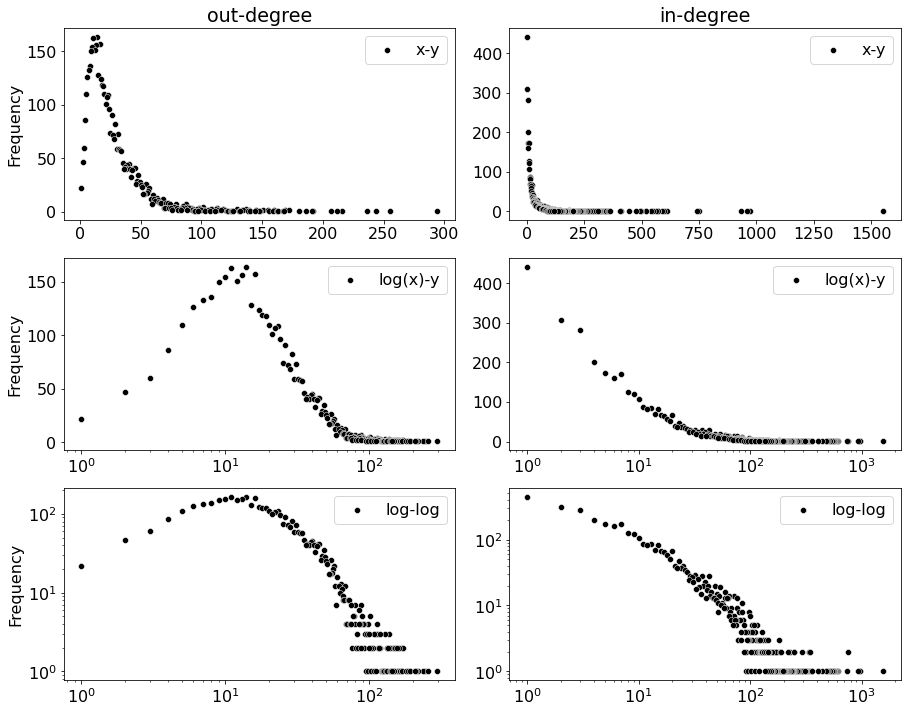

In [7]:
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(3,2,
                       figsize=(15,12),
                       gridspec_kw={'wspace':0.14})

labels = ["x-y", "log(x)-y", "log-log"]
for i in range(3):
    sns.scatterplot(data = df['out'].value_counts().value_counts(), 
                    ax=ax[i,0], color='k', label=labels[i])
    sns.scatterplot(data = df['in'].value_counts().value_counts(), 
                    ax=ax[i,1], color='k', label=labels[i])

ax[0, 0].set_title("out-degree")
ax[0, 1].set_title("in-degree")

for i in range(2):
    # Set log scale in x for second row plots
    ax[1,i].set_xscale('log')
    # log-log scale in 3rd row
    ax[2,i].set_xscale('log')
    ax[2,i].set_yscale('log')
    
for i in range(3):
    ax[i, 0].set_ylabel("Frequency")
    ax[i, 1].set_ylabel("")
    
plt.legend();

### Distributions of in- and out- degree are very different.

- in-degree distribution is more power-law-like. The lowest the in-degree, the higher frequency.
- out-degree has a more likely value of around 15. 

# TODO

- Distribution of in-links and out-links per node
- Test hypothesis: visit frequency correlates with node in-degree.

In [26]:
# Ukraine_A is not in this df (meaning no link points to it)
degree_freq[degree_freq.index.str.startswith("Ukraine")]

,in,out
Ukraine,171,58


# Load actual paths. Check frequency

In [64]:
def split_decode_path(path):
    pathl = path.split(";")
    return list(map(
        urllib.parse.unquote, 
        pathl
    ))

df_paths_success = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv", 
                          skiprows=15, 
                          sep="\t", 
                          header=None)
                    .rename(columns={0:"ip",
                                     1:"timestamp",
                                     2:"duration",
                                     3:"path",
                                     4:"rating"})
         )
# Create a "target" col
df_paths_success["target"] = (df_paths_success["path"]
                              .apply(lambda x: x.split(";")[-1]))
df_paths_success["type"] = "win"


df_paths_fail = (pd.read_csv("wikispeedia/wikispeedia_paths-and-graph/paths_unfinished.tsv", 
                             skiprows=16, 
                             sep="\t", 
                             header=None)
                 .rename(columns={0:"ip",
                                  1:"timestamp",
                                  2:"duration",
                                  3:"path",
                                  4:"target",
                                  5:"type"})
             )

# Join dfs to get a full df with all paths
df_paths = pd.concat([df_paths_success,
                      df_paths_fail])

# Get path list
df_paths["pathl"] = df_paths["path"].apply(split_decode_path)
# Decode target from url
df_paths["target"] = df_paths["target"].apply(urllib.parse.unquote)
# Get starting node
df_paths["start"] = df_paths["pathl"].apply(lambda x:x[0])

df_paths.sample(5)

,ip,timestamp,duration,path,rating,target,type,pathl,start
22886,0eab80783b848d56,1251087154,53,Cyprus;United_Nations;Taiwan;Taipei,1.0,Taipei,win,"[Cyprus, United_Nations, Taiwan, Taipei]",Cyprus
5377,7e9ca3ef71aad4e1,1312523984,151,Theatre;Actor;<;United_States;Country;<;North_...,NaN,Zebra,restart,"[Theatre, Actor, <, United_States, Country, <,...",Theatre
39094,7555202a4b1690fc,1365990557,215,Funchal;16th_century;Leonardo_da_Vinci;Astrono...,NaN,Elementary_algebra,win,"[Funchal, 16th_century, Leonardo_da_Vinci, Ast...",Funchal
20891,1cf0cbb3281049ab,1389055521,69,Pyramid;Sun;Photosynthesis;Plant;Soybean;Seed;...,3.0,Bean,win,"[Pyramid, Sun, Photosynthesis, Plant, Soybean,...",Pyramid
33311,109ed71f571d86e9,1389786179,116,Damascus_steel;Arabic_language;North_Africa;Af...,NaN,Race,win,"[Damascus_steel, Arabic_language, North_Africa...",Damascus_steel


# Selection of starting and ending nodes: Is it uniformly distributed?

In [63]:
degree_freq_ = (pd.merge(degree_freq,
                       pd.DataFrame(
                           df_paths["target"]
                           .value_counts()
                       ),
                        left_index=True,
                        right_index=True,
                        how="outer"
                      ).merge

degree_freq_

,in,out,target
10th_century,65.0,26.0,7.0
11th_century,57.0,48.0,13.0
12th_century,85.0,45.0,10.0
13th_century,84.0,34.0,34.0
14th_century,71.0,31.0,11.0
...,...,...,...
Zoroaster,9.0,28.0,5.0
Zuid-Gelders,5.0,5.0,11.0
Zulu,14.0,15.0,9.0
Zürich,20.0,20.0,6.0


In [72]:
degree_freq_.iloc[-1]

in        NaN
out       NaN
target    1.0
Name: _Zebra, dtype: float64

In [58]:
pd.DataFrame(df_paths["start"].value_counts())

,start
Brain,2113
Theatre,1823
Asteroid,1804
Pyramid,1627
Batman,947
...,...
Outer_Hebrides,1
David_Heymann,1
Hurricane_John_(1994),1
Psittacosaurus,1


In [55]:
degree_freq

,in,out
United_States,1551,294
United_Kingdom,972,168
France,959,85
Europe,933,159
England,751,172
...,...,...
History_of_Greenland,1,37
History_of_Arizona,1,50
History_of_Alaska,1,30
Ateneo_de_Manila_University,1,16
